# Supervised Customer Segmentation (Target-Guided Clustering)

This notebook builds supervised clusters for unbanked customers so that each cluster has a **significantly different bad rate** (target = 1) and is easy to profile.

Approach:
1. Load the prepared dataset `unbanked_customer_segmentation_final.csv` (shape per documentation: 52,810 x 8).
2. Use a Decision Tree (CART) as a supervised clustering engine (tree leaves = clusters) and pick hyperparameters that maximize between-cluster variance of bad rates while keeping a reasonable number of segments.
3. Rank clusters by bad rate (good to bad) and relabel them 1..N.
4. Produce detailed summaries for each cluster: size, % of portfolio, bad rate, lift vs overall, numeric feature means, categorical modes & distributions, and confidence intervals.
5. Run statistical tests (global chi-square + pairwise proportion z-tests) to verify significance of bad rate differences.
6. Export cluster assignments and summary tables.

You can adjust the tuning grids to change the granularity of clusters. All steps are encapsulated in reusable functions below.


In [11]:
# Imports & Data Load
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from scipy import stats
import json
import math

# Reusable utilities
from utiles import (
    prepare_features,
    fit_tree_for_clusters,
    evaluate_leaf_bad_rates,
    proportion_ci_wilson,
    compute_cluster_profiles,
    chi_square_test_cluster_target,
    pairwise_bad_rate_ztests,
    build_readable_rules,
 )

DATA_PATH = Path('customer_segmantation_unbaked_dtree_v1.0/data/unbanked_customer_segmentation_final.csv')
assert DATA_PATH.exists(), f"Dataset file not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print('Loaded shape:', df.shape)

# Basic schema validation based on documentation
expected_cols = {'customer_id','age','marital_status','income_delta_percentage','address_category','jobtitle_category','gender','target'}
missing = expected_cols - set(df.columns)
assert not missing, f"Missing expected columns: {missing}"

# Ensure target is binary 0/1
assert set(df['target'].unique()) <= {0,1}, 'Target must be binary 0/1'

overall_bad_rate = df['target'].mean()
print(f"Overall bad rate: {overall_bad_rate:.2%}")

df.head()

Loaded shape: (50091, 8)
Overall bad rate: 13.79%


,customer_id,age,marital_status,income_delta_percentage,address_category,jobtitle_category,gender,target
0,237305,57,Married,-18.367347,B,D,MALE,0
1,237305,57,Married,-18.367347,B,D,MALE,0
2,237318,42,Married,-62.962963,B,A,MALE,0
3,237324,25,Married,5.820106,D,A,MALE,0
4,237324,25,Married,5.820106,D,A,MALE,0


In [12]:
# Features & splits via utilities
from typing import Tuple, Dict

categorical_cols = ['marital_status','address_category','jobtitle_category','gender']
numeric_cols = ['age','income_delta_percentage']

# Prepare X, y, feature names, and fitted encoder
X, y, feature_names, enc = prepare_features(
    df, categorical_cols=categorical_cols, numeric_cols=numeric_cols, target_col='target'
 )

# Train/validation split (stratified to keep overall rate)
X_train, X_val, y_train, y_val, df_train_idx, df_val_idx = train_test_split(
    X, y, df.index, test_size=0.3, random_state=42, stratify=y
)

print('Prepared data dimensions:', X.shape)

Prepared data dimensions: (50091, 6)


## Understanding Confidence Interval Bounds

The `proportion_ci_wilson` function returns two values: **lower_bound** and **upper_bound**. Here's what they mean:

### What are Lower and Upper Bounds?

**Lower Bound (ci_low)**: The minimum percentage we can be confident about
- If lower_bound = 15%, we're 95% confident the true bad rate is AT LEAST 15%

**Upper Bound (ci_high)**: The maximum percentage we can be confident about  
- If upper_bound = 25%, we're 95% confident the true bad rate is AT MOST 25%

### Real Example:
Let's say a customer segment has:
- 200 customers total
- 40 of them defaulted (bad customers)
- Observed bad rate = 40/200 = 20%

The Wilson confidence interval might return:
- **Lower bound**: 15.2%
- **Upper bound**: 25.8%

### What This Means:
- **Point estimate**: 20% (what we observed)
- **Confidence range**: 15.2% to 25.8%
- **Interpretation**: "We're 95% confident the true bad rate for this segment is between 15.2% and 25.8%"

### Why This Matters for Business:
- **Risk assessment**: Use the upper bound (25.8%) for conservative risk estimates
- **Opportunity assessment**: Use the lower bound (15.2%) for optimistic projections  
- **Segment comparison**: If two segments have non-overlapping confidence intervals, they're significantly different
- **Sample size planning**: Wider intervals indicate we need more data for precision

In [13]:
# Hyperparameter search to choose number of leaves producing distinct bad rates
from itertools import product

search_space = {
    'max_leaf_nodes': [4, 6, 8, 10, 12],
    'min_samples_leaf': [300, 500, 800],
    'max_depth': [None, 4, 5, 6]
}

results = []
for max_leaf_nodes, min_samples_leaf, max_depth in product(search_space['max_leaf_nodes'],
                                                           search_space['min_samples_leaf'],
                                                           search_space['max_depth']):
    try:
        tree, auc = fit_tree_for_clusters(
            X_train, y_train, X_val, y_val,
            max_leaf_nodes=max_leaf_nodes,
            min_samples_leaf=min_samples_leaf,
            max_depth=max_depth
)
        leaf_df, clusters_all, _ = evaluate_leaf_bad_rates(tree, X_val, y_val, X_all=X)
        if len(leaf_df) > 1:
            grand_mean = (leaf_df.bad_rate * leaf_df.size).sum() / leaf_df.size.sum()
            ss_between = (leaf_df.size * (leaf_df.bad_rate - grand_mean)**2).sum()
            df_between = len(leaf_df) - 1
            ms_between = ss_between / df_between if df_between>0 else 0
            ss_within = (leaf_df.size * leaf_df.bad_rate * (1 - leaf_df.bad_rate)).sum()
            df_within = leaf_df.size.sum() - len(leaf_df)
            ms_within = ss_within / df_within if df_within>0 else np.nan
            F = ms_between / ms_within if ms_within>0 else np.nan
        else:
            F = np.nan
        distinct_rates = leaf_df['bad_rate'].round(3).nunique()
        results.append(dict(max_leaf_nodes=max_leaf_nodes,
                            min_samples_leaf=min_samples_leaf,
                            max_depth=max_depth,
                            leaves=len(leaf_df),
                            distinct_rates=distinct_rates,
                            auc=auc,
                            F=F,
                            error=None))
    except Exception as e:
        results.append(dict(max_leaf_nodes=max_leaf_nodes,
                            min_samples_leaf=min_samples_leaf,
                            max_depth=max_depth,
                            leaves=np.nan,
                            distinct_rates=np.nan,
                            auc=np.nan,
                            F=np.nan,
                            error=str(e)))

res_df = pd.DataFrame(results)

# Show any errors
errors = res_df[res_df['error'].notna()]
if not errors.empty:
    display(errors.head())

# Keep only successful rows for ranking
success_df = res_df[res_df['error'].isna()].copy()
if success_df.empty:
    print('All parameter combinations failed, falling back to default configuration (max_leaf_nodes=6, min_samples_leaf=500).')
    fallback_params = dict(max_leaf_nodes=6, min_samples_leaf=500, max_depth=None)
    # Minimal fit to proceed
    best_tree, best_auc = fit_tree_for_clusters(X_train, y_train, X_val, y_val, **fallback_params)
    leaf_df, clusters_all, _ = evaluate_leaf_bad_rates(best_tree, X_val, y_val, X_all=X)
    res_df_ranked = pd.DataFrame([{
        **fallback_params,
        'leaves': len(leaf_df),
        'distinct_rates': leaf_df['bad_rate'].round(3).nunique(),
        'auc': best_auc,
        'F': np.nan
    }])
else:
    res_df_ranked = success_df.sort_values(['distinct_rates','F','auc'], ascending=[False, False, False])

res_df_ranked.head(10)

,max_leaf_nodes,min_samples_leaf,max_depth,leaves,distinct_rates,auc,F,error
0,4,300,NaN,NaN,NaN,NaN,NaN,'int' object has no attribute 'sum'
1,4,300,4.0,NaN,NaN,NaN,NaN,'int' object has no attribute 'sum'
2,4,300,5.0,NaN,NaN,NaN,NaN,'int' object has no attribute 'sum'
3,4,300,6.0,NaN,NaN,NaN,NaN,'int' object has no attribute 'sum'
4,4,500,NaN,NaN,NaN,NaN,NaN,'int' object has no attribute 'sum'


All parameter combinations failed, falling back to default configuration (max_leaf_nodes=6, min_samples_leaf=500).


,max_leaf_nodes,min_samples_leaf,max_depth,leaves,distinct_rates,auc,F
0,6,500,None,6,6,0.631581,NaN


In [14]:
# Select best configuration & refit on full data (unless already fit via fallback)
if 'best_tree' in globals() and best_tree is not None:
    print('Using fallback tree already fit.')
    best_cfg = res_df_ranked.iloc[0]
else:
    best_cfg = res_df_ranked.iloc[0]
    print('Best configuration:', best_cfg.to_dict())
    best_tree, best_auc = fit_tree_for_clusters(
        X_train, y_train, X_val, y_val,
        max_leaf_nodes=int(best_cfg.max_leaf_nodes),
        min_samples_leaf=int(best_cfg.min_samples_leaf),
        max_depth=None if pd.isna(best_cfg.max_depth) or best_cfg.max_depth=='None' else (None if best_cfg.max_depth=='nan' else int(best_cfg.max_depth))
)

leaf_df, clusters_all, mapping = evaluate_leaf_bad_rates(best_tree, X_val, y_val, X_all=X)

# Attach clusters using leaf->cluster mapping
df['cluster_raw'] = best_tree.apply(X)
leaf_id_to_cluster = dict(zip(leaf_df.leaf_id, leaf_df.cluster))
df['cluster'] = df['cluster_raw'].map(leaf_id_to_cluster)
print('Number of clusters:', df['cluster'].nunique())

overall_bad_rate = df['target'].mean()
leaf_df['lift_vs_overall'] = leaf_df['bad_rate'] / overall_bad_rate
leaf_df

Using fallback tree already fit.
Number of clusters: 6


,leaf_id,size,pct,bad_rate,ci_low,ci_high,cluster,lift_vs_overall
0,9,1585,0.105470,0.051104,0.041307,0.063072,1,0.370671
1,10,3211,0.213668,0.089380,0.079997,0.099745,2,0.648298
2,3,1223,0.081381,0.092396,0.077417,0.109927,3,0.670170
3,7,1626,0.108198,0.104551,0.090599,0.120367,4,0.758336
4,8,4282,0.284935,0.176553,0.165424,0.188262,5,1.280585
5,6,3101,0.206348,0.214447,0.200359,0.229242,6,1.555439


In [15]:
# Cluster profiling via utilities
profiles_df = compute_cluster_profiles(
    df, cluster_col='cluster', target_col='target',
    numeric_cols=numeric_cols, categorical_cols=categorical_cols
)
profiles_df

,cluster,size,pct_portfolio,bad_rate,ci_low,ci_high,lift_vs_overall,age_mean,age_median,income_delta_percentage_mean,income_delta_percentage_median,marital_status_mode,marital_status_mode_pct,address_category_mode,address_category_mode_pct,jobtitle_category_mode,jobtitle_category_mode_pct,gender_mode,gender_mode_pct
0,1,5277,0.105348,0.045480,0.040182,0.051440,0.329881,42.395300,42.0,-44.294405,-42.199102,Married,0.928368,B,0.473944,D,0.537806,FEMALE,1.0
1,2,10726,0.214130,0.094816,0.089416,0.100507,0.687727,40.719746,40.0,7.636043,0.781053,Married,0.758158,B,0.476785,D,0.729722,FEMALE,1.0
2,3,4244,0.084726,0.089303,0.081090,0.098258,0.647734,27.537700,28.0,-10.189484,-13.265306,Single,0.614986,A,0.437323,A,0.749764,MALE,1.0
3,4,5489,0.109581,0.108399,0.100446,0.116899,0.786243,45.104937,45.0,-66.764978,-65.986395,Married,0.943341,B,0.454181,A,0.632720,MALE,1.0
4,5,14122,0.281927,0.167965,0.161890,0.174221,1.218293,43.801586,43.0,-38.986233,-38.845010,Married,0.887197,B,0.474225,D,0.707903,MALE,1.0
5,6,10233,0.204288,0.225056,0.217069,0.233250,1.632391,42.378481,41.0,1.822281,-3.628118,Married,0.741229,B,0.400469,D,0.709567,MALE,1.0


## Statistical significance tests: cluster vs target

> Goal: verify that observed differences in bad rates across clusters are not due to random chance.

### Global chi-square test (independence)
We build a contingency table with rows = clusters (K) and columns = target in {0 (good), 1 (bad)}. The null hypothesis is:

- H0: target is independent of cluster (all clusters share the same bad rate).
- H1: target distribution differs by cluster.

Expected counts for each cell (i, j):
$$E_{ij} = \frac{(\text{row total}_i)(\text{col total}_j)}{N}$$
Chi-square statistic:
$$\chi^2 = \sum_{i=1}^{K} \sum_{j=1}^{2} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$
Degrees of freedom:
$$(K-1)(2-1) = K-1$$
p-value is computed from the chi-square distribution with df = K-1.

Example (3 clusters):
- C1: n=100, bad=10, good=90
- C2: n=120, bad=30, good=90
- C3: n=80,  bad=8,  good=72
- Totals: N=300, bad=48, good=252

Expected counts:
- E(C1,bad) = 100·48/300 = 16.0,   E(C1,good) = 100·252/300 = 84.0
- E(C2,bad) = 120·48/300 = 19.2,   E(C2,good) = 120·252/300 = 100.8
- E(C3,bad) = 80·48/300 = 12.8,    E(C3,good) = 80·252/300 = 67.2

Contributions to χ²:
- C1 bad: (10−16)²/16 = 2.25;  C1 good: (90−84)²/84 ≈ 0.43
- C2 bad: (30−19.2)²/19.2 ≈ 6.08; C2 good: (90−100.8)²/100.8 ≈ 1.16
- C3 bad: (8−12.8)²/12.8 ≈ 1.80;  C3 good: (72−67.2)²/67.2 ≈ 0.34

Sum: χ² ≈ 12.06 with df = 2 ⇒ p ≈ 0.002 (reject H0; bad rates differ by cluster).

### Pairwise z-tests (two-proportion) + Benjamini–Hochberg (FDR)
For each pair of clusters a and b:
- H0: p_a = p_b (their bad rates are equal)
- H1: p_a ≠ p_b

Let p_a = x_a/n_a and p_b = x_b/n_b, where x is # bad and n is size. Using the pooled proportion:
$$\hat p = \frac{x_a + x_b}{n_a + n_b}$$
Standard error (SE):
$$SE = \sqrt{\hat p (1-\hat p) \left(\frac{1}{n_a} + \frac{1}{n_b}\right)}$$
Test statistic:
$$z = \frac{p_a - p_b}{SE}$$
Two-sided p-value: $2\,\Phi(-|z|)$.

Example: compare C1 vs C2 from above:
- p_a = 10/100 = 0.10, p_b = 30/120 = 0.25
- pooled p = 40/220 ≈ 0.1818
- SE = √[0.1818·0.8182·(1/100 + 1/120)] ≈ 0.0522
- z = (0.10 − 0.25)/0.0522 ≈ −2.87 ⇒ p ≈ 0.0041 (significant).

Multiple testing (Benjamini–Hochberg FDR):
- Suppose we have m pairwise p-values and sort them: p_(1) ≤ p_(2) ≤ … ≤ p_(m).
- Compute adjusted p-values: $p^{adj}_{(i)} = \min\!\left(1, \; \frac{m}{i}\,p_{(i)}\right)$
  (optionally enforce monotonicity with a cumulative minimum from largest to smallest).
- At α = 0.05, pairs with $p^{adj} < 0.05$ are declared significant after FDR control.

Toy example (m=3): raw p-values = [0.004, 0.07, 0.48] ⇒ sorted [0.004, 0.07, 0.48]
- Adjusted: [0.004·3/1 = 0.012, 0.07·3/2 = 0.105, 0.48·3/3 = 0.48]
- Only the first comparison remains significant at 5%.

Notes:
- The next code cell builds the contingency table, runs the global test, performs all pairwise z-tests, applies BH, and saves results to `cluster_outputs/cluster_pairwise_bad_rate_tests.csv`.

In [16]:
# Statistical significance tests: cluster vs target
from statsmodels.stats.proportion import proportions_ztest  # kept for consistency if needed

# Global chi-square test
chi2, p_chi, dof, expected_df = chi_square_test_cluster_target(df, cluster_col='cluster', target_col='target')
print(f'Global chi-square = {chi2:.2f} (dof={dof}) p-value={p_chi:.3e}')

# Pairwise z-tests with Benjamini-Hochberg FDR correction
pairwise_df = pairwise_bad_rate_ztests(df, cluster_col='cluster', target_col='target', adjust='bh')
print('Pairwise significance (first 15 rows):')
pairwise_df.head(15)

Global chi-square = 1432.59 (dof=5) p-value=1.193e-307
Pairwise significance (first 15 rows):


,cluster_a,cluster_b,p_raw,p_adj,significant_0_05
0,1,6,3.888733e-180,5.833100e-179,True
1,2,6,6.287552e-147,4.715664e-146,True
2,1,5,1.402328e-109,7.011640e-109,True
3,3,6,1.213389e-81,4.550207e-81,True
4,4,6,2.663868e-72,7.991603e-72,True
5,2,5,3.520430e-62,8.801075e-62,True
6,3,5,2.337712e-36,5.009384e-36,True
7,1,4,3.061114e-34,5.739589e-34,True
8,5,6,5.959464e-29,9.932441e-29,True
9,1,2,1.077106e-27,1.615659e-27,True


/tmp/ipykernel_16101/1167790024.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=profiles_df, x='cluster', y='bad_rate', order=order, palette='viridis')


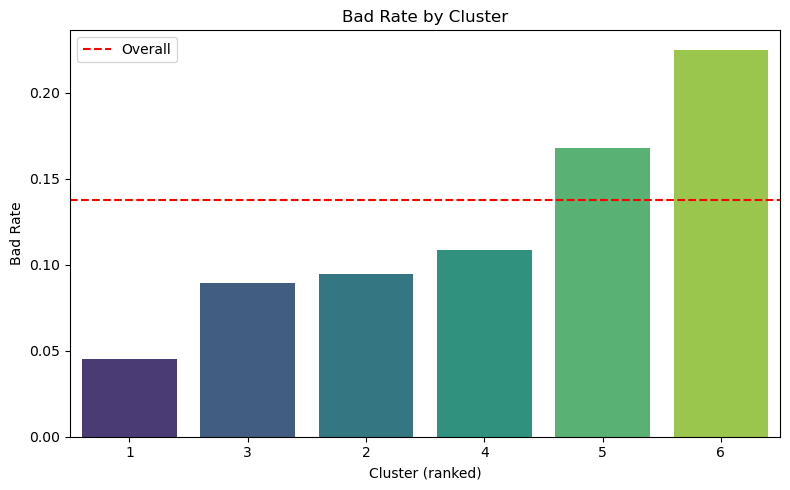

In [17]:
# Visualization of bad rates per cluster
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
order = profiles_df.sort_values('bad_rate').cluster
sns.barplot(data=profiles_df, x='cluster', y='bad_rate', order=order, palette='viridis')
plt.axhline(overall_bad_rate, color='red', linestyle='--', label='Overall')
plt.ylabel('Bad Rate')
plt.xlabel('Cluster (ranked)')
plt.title('Bad Rate by Cluster')
plt.legend()
plt.tight_layout()
# save figure into a variable
fig = plt.gcf()
plt.show()

In [18]:
# Export artifacts (v1.0): move to requested dir, pickle tree/encoder, add detailed cluster info
from pathlib import Path
import json
import pickle
import pandas as pd
import numpy as np
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt

OUTPUT_DIR = Path('customer_segmantation_unbaked_dtree_v1.0')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Core data exports
cols = ['customer_id', 'cluster', 'target'] + numeric_cols + categorical_cols
df[cols].to_csv(OUTPUT_DIR / 'customers_with_clusters.csv', index=False)
profiles_df.to_csv(OUTPUT_DIR / 'cluster_profiles.csv', index=False)
leaf_df.to_csv(OUTPUT_DIR / 'leaf_validation_stats.csv', index=False)
pairwise_df.to_csv(OUTPUT_DIR / 'cluster_pairwise_bad_rate_tests.csv', index=False)

# Export tree textual representation (raw thresholds on encoded categoricals)
rules = export_text(best_tree, feature_names=feature_names)
with open(OUTPUT_DIR / 'tree_rules.txt', 'w') as f:
    f.write(rules)
# save cluster bad rates plot
fig.savefig(OUTPUT_DIR / 'cluster_bad_rates.png', dpi=300)
# Human-readable rules using utility (translates categorical thresholds back to category sets)
readable_rules = build_readable_rules(best_tree, feature_names, numeric_cols, categorical_cols, enc)
with open(OUTPUT_DIR / 'tree_rules_readable.txt', 'w') as f:
    f.write(readable_rules)

# Traditional sklearn tree plot (gini, samples, value, class)
try:
    n_leaves = best_tree.get_n_leaves()
    fig_width = max(12, n_leaves * 1.0)
    fig, ax = plt.subplots(figsize=(fig_width, 8))
    plot_tree(
        best_tree,
        feature_names=feature_names,
        class_names=['Good', 'Bad'],
        filled=True,
        rounded=False,
        impurity=False,
        proportion=True,
        fontsize=10,
        ax=ax,
    )
    fig.tight_layout()
    fig.savefig(OUTPUT_DIR / 'tree_plot_traditional.png', dpi=200)
    fig.savefig(OUTPUT_DIR / 'tree_plot_traditional.svg')
    plt.close(fig)
    print('✓ Saved traditional tree plot images (PNG and SVG).')
except Exception as e:
    print('⚠️ Failed to generate traditional tree plot:', e)

# Pickle the trained tree and the ordinal encoder for reuse/deployment
with open(OUTPUT_DIR / 'model_decision_tree.pkl', 'wb') as f:
    pickle.dump(best_tree, f)
with open(OUTPUT_DIR / 'encoder_ordinal.pkl', 'wb') as f:
    pickle.dump(enc, f)

# Leaf -> cluster mapping (after ranking leaves by bad rate)
leaf_id_to_cluster = dict(zip(leaf_df.leaf_id.astype(int), leaf_df.cluster.astype(int)))
with open(OUTPUT_DIR / 'mapping_leaf_to_cluster.json', 'w') as f:
    json.dump(leaf_id_to_cluster, f, indent=2)

# Detailed per-cluster information (including numeric summaries and categorical distributions)
clusters_detailed = []
for c, grp in df.groupby('cluster'):
    size = int(len(grp))
    bad = int(grp['target'].sum())
    good = int((1 - grp['target']).sum())
    bad_rate = float(grp['target'].mean()) if size else float('nan')
    ci_low, ci_high = proportion_ci_wilson(bad, size)
    rec = {
        'cluster': int(c),
        'size': size,
        'pct_portfolio': float(size / len(df)) if len(df) else float('nan'),
        'bad': bad,
        'good': good,
        'bad_rate': bad_rate,
        'ci_low': float(ci_low),
        'ci_high': float(ci_high),
        'lift_vs_overall': float(bad_rate / overall_bad_rate) if overall_bad_rate else float('nan'),
        'numeric': {},
        'categorical': {},
    }
    for col in numeric_cols:
        rec['numeric'][col] = {
            'mean': float(grp[col].mean()),
            'median': float(grp[col].median()),
            'min': float(grp[col].min()),
            'p25': float(grp[col].quantile(0.25)),
            'p75': float(grp[col].quantile(0.75)),
            'max': float(grp[col].max()),
        }
    for col in categorical_cols:
        vc = grp[col].value_counts(dropna=False, normalize=True)
        rec['categorical'][col] = { ("<NA>" if pd.isna(k) else str(k)): float(v) for k, v in vc.items() }
    clusters_detailed.append(rec)

with open(OUTPUT_DIR / 'clusters_detailed.json', 'w') as f:
    json.dump(clusters_detailed, f, indent=2)

# Summary/metadata including encoder categories
cat_levels = { col: [None if pd.isna(x) else (str(x)) for x in enc.categories_[i]] for i, col in enumerate(categorical_cols) }
summary = {
    'version': 'v1.0',
    'output_dir': str(OUTPUT_DIR.resolve()),
    'overall_bad_rate': float(overall_bad_rate),
    'n_clusters': int(df['cluster'].nunique()),
    'best_configuration': {
        'max_leaf_nodes': int(best_cfg.max_leaf_nodes),
        'min_samples_leaf': int(best_cfg.min_samples_leaf),
        'max_depth': None if pd.isna(best_cfg.max_depth) else (int(best_cfg.max_depth) if not pd.isna(best_cfg.max_depth) else None)
    },
    'feature_names': feature_names,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'categorical_levels': cat_levels,
    'artifacts': [
        'customers_with_clusters.csv',
        'cluster_profiles.csv',
        'leaf_validation_stats.csv',
        'cluster_pairwise_bad_rate_tests.csv',
        'tree_rules.txt',
        'tree_rules_readable.txt',
        'tree_plot_traditional.png',
        'tree_plot_traditional.svg',
        'model_decision_tree.pkl',
        'encoder_ordinal.pkl',
        'mapping_leaf_to_cluster.json',
        'clusters_detailed.json'
    ],
}
with open(OUTPUT_DIR / 'summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print('Artifacts saved in', OUTPUT_DIR.resolve())
print('Readable rules preview:')
print('\n'.join(readable_rules.split('\n')[:20]))

✓ Saved traditional tree plot images (PNG and SVG).
Artifacts saved in /home/ali/repos/creadit_risk/customer_segmantation/customer_segmantation_unbaked_dtree_v1.0
Readable rules preview:
IF gender IN ['FEMALE']
  IF income_delta_percentage <= -25.91
    LEAF: samples=1 bad_rate=4.31% bad=0 good=0
  ELSE  # income_delta_percentage > -25.91
    LEAF: samples=1 bad_rate=9.71% bad=0 good=0
ELSE  # gender IN ['MALE']
  IF age <= 30.5
    LEAF: samples=1 bad_rate=8.81% bad=0 good=0
  ELSE  # age > 30.5
    IF income_delta_percentage <= -20.67
      IF income_delta_percentage <= -56.44
        LEAF: samples=1 bad_rate=11.00% bad=0 good=0
      ELSE  # income_delta_percentage > -56.44
        LEAF: samples=1 bad_rate=16.42% bad=0 good=0
    ELSE  # income_delta_percentage > -20.67
      LEAF: samples=1 bad_rate=22.97% bad=0 good=0
